In [1]:
from base import *
from utils import *
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import PauliSumOp, AerPauliExpectation
from qiskit.circuit import Parameter
import numpy as np
import seaborn as sns



## The simple hamiltonian
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad \mathcal{E} = \frac{E_1
  + E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
c = (V_{11}+V_{22})/2, 
$$ 
$$
\omega_z = (V_{11}-V_{22})/2, 
$$
$$
\omega_x = V_{12}=V_{21}
$$

In [2]:
# Constants
E_1 = 0
E_2 = 4 
V_11 = 3
V_22 = -3
V_12 = 0.2
V_21 = 0.2
epsilon = (E_1+E_2) / 2
Omega = (E_1-E_2) / 2
c = (V_11 + V_22) / 2
omega_z = (V_11 - V_22) / 2
omega_x = V_12

# Variables
# lmb = 1 # Interaction strength


### Classical numerical solver for the eigenvalues

In [3]:
H_0 = np.array([[E_1, 0],
               [0, E_2]])
H_1 = np.array([[V_11, V_12],
               [V_21, V_22]])


lmbs = np.arange(0, 1, 0.001)
eigs = np.zeros((2, len(lmbs)))

for i, lmb in enumerate(lmbs):
    result = np.linalg.eig(H_0 + lmb * H_1)[0]
    eigs[:,i] = max(result), min(result)

# print(eigs)
# print(lmbs.shape)
plt.plot(lmbs, eigs[0], label='E_0')
plt.plot(lmbs, eigs[1], label='E_1')
plt.plot(np.array([2/3 for _ in range(100)]), np.linspace(0, 4, 100), label=r'$\lambda=2/3$'),
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Eigenvalues')
plt.legend()
save_fig('eigs-1-cl.pdf')


### Quantum Computing 

First we need to rewrite the hamiltonian in terms of Pauli matrices.
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad 
\mathcal{E} = \frac{E_1+ E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
\lambda H_I = \lambda c \boldsymbol{I} + \lambda \omega_z\sigma_z + \lambda \omega_x \sigma_x 
$$
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [4]:
q2 = Qubits_2()

# set up bell state
q2.hadamard(0)
q2.measure(1000)

[(502, '00'), (0, '01'), (498, '10'), (0, '11')]

Set up

In [7]:

def H(lmb):
    return PauliSumOp.from_list([('X', lmb*omega_x), 
                                 ('Z', Omega+lmb*omega_z), 
                                 ('I', lmb*c+epsilon)]) # Hamiltonian using operators

def ansatz():
    # creates an ansatz that are functions of the parameters TODO: maybe can be changed to Hartree Fock initial state? 
    # from HartreeFock.construct_circuit()
    theta = Parameter('theta')
    phi = Parameter('phi')
    qc = QuantumCircuit(1)
    qc.rx(theta,0)
    qc.ry(phi,0)
    return qc


def prep_vqe():
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter=10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.



In [8]:
# Define the backend to run the quantum circuit
n_points=1000


lmbs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe()
energies = np.zeros(n_points) # containers for the energies

for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    ham = H(lmb)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'lmb = {lmb}, energy = {result.eigenvalue.real}')




0.0 * X
- 2.0 * Z
+ 2.0 * I
lmb = 0.0, energy = 2.1322429399894816e-07
0.0002 * X
- 1.997 * Z
+ 2.0 * I
lmb = 0.001, energy = 0.0030001939951225243
0.0004 * X
- 1.994 * Z
+ 2.0 * I
lmb = 0.002, energy = 0.006000154978124117
0.0006000000000000001 * X
- 1.991 * Z
+ 2.0 * I
lmb = 0.003, energy = 0.009000096136579705
0.0008 * X
- 1.988 * Z
+ 2.0 * I
lmb = 0.004, energy = 0.012000017290968223
0.001 * X
- 1.985 * Z
+ 2.0 * I
lmb = 0.005, energy = 0.014999918408014068
0.0012000000000000001 * X
- 1.982 * Z
+ 2.0 * I
lmb = 0.006, energy = 0.017999799363956015
0.0014000000000000002 * X
- 1.979 * Z
+ 2.0 * I
lmb = 0.007, energy = 0.02099966004862308
0.0016 * X
- 1.976 * Z
+ 2.0 * I
lmb = 0.008, energy = 0.02399950037276155
0.0018 * X
- 1.973 * Z
+ 2.0 * I
lmb = 0.009, energy = 0.02699932023042595
0.002 * X
- 1.97 * Z
+ 2.0 * I
lmb = 0.01, energy = 0.029999119517164274
0.0022 * X
- 1.967 * Z
+ 2.0 * I
lmb = 0.011, energy = 0.03299889813665913
0.0024000000000000002 * X
- 1.964 * Z
+ 2.0 * I
lmb = 0

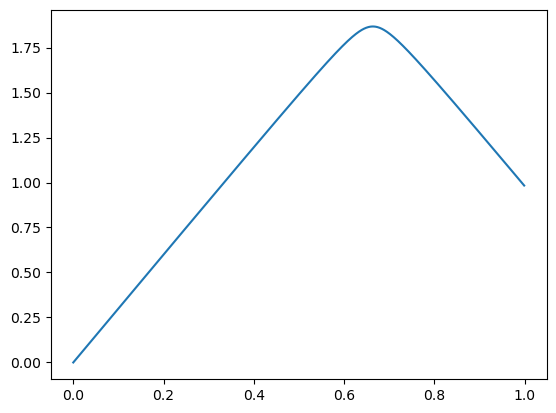

In [9]:
plt.plot(lmbs/n_points, energies)
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [10]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [theta, phi]'''
    qc = Qubit()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    return qc

def my_H(lmb):
    # computes the hamiltonian
    return pauli_sum([('X', lmb*omega_x), 
                      ('Z', Omega+lmb*omega_z), 
                      ('I', lmb*c+epsilon)])




In [11]:
a = my_ansatz((np.pi/2,np.pi/2))
a

Qubit(s) in state: 
 0.50+0.50j|0⟩ + 0.50-0.50j|1⟩ 

In [12]:
from algorithms import Vqe 

In [16]:
n_points = 1000

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=2)
my_vqe = Vqe(my_ansatz, init_points)

my_energies = np.zeros(n_points)
lmbs = np.arange(n_points)
for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    print(lmb)
    my_ham = my_H(lmb)
    print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham)
    print(f"lambda: {lmb}, energy: {min_energy}")
    my_energies[i] = min_energy



0.0
[[0. 0.]
 [0. 4.]]
lambda: 0.0, energy: 5.727892531852036e-13
0.001
[[3.000e-03 2.000e-04]
 [2.000e-04 3.997e+00]]
lambda: 0.001, energy: 0.002999989985593049
0.002
[[6.000e-03 4.000e-04]
 [4.000e-04 3.994e+00]]
lambda: 0.002, energy: 0.005999959880301134
0.003
[[9.000e-03 6.000e-04]
 [6.000e-04 3.991e+00]]
lambda: 0.003, energy: 0.00899990959388241
0.004
[[1.200e-02 8.000e-04]
 [8.000e-04 3.988e+00]]
lambda: 0.004, energy: 0.011999839034976345
0.005
[[1.500e-02 1.000e-03]
 [1.000e-03 3.985e+00]]
lambda: 0.005, energy: 0.014999748111668662
0.006
[[1.800e-02 1.200e-03]
 [1.200e-03 3.982e+00]]
lambda: 0.006, energy: 0.01799963673149171
0.007
[[2.100e-02 1.400e-03]
 [1.400e-03 3.979e+00]]
lambda: 0.007, energy: 0.02099950480141559
0.008
[[2.400e-02 1.600e-03]
 [1.600e-03 3.976e+00]]
lambda: 0.008, energy: 0.02399935222784714
0.009
[[2.700e-02 1.800e-03]
 [1.800e-03 3.973e+00]]
lambda: 0.009, energy: 0.02699917891662462
0.01
[[3.00e-02 2.00e-03]
 [2.00e-03 3.97e+00]]
lambda: 0.01, ener

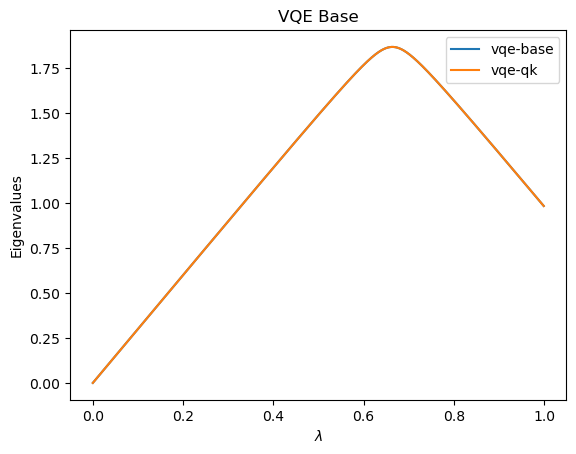

In [18]:

plt.plot(lmbs/n_points, my_energies, label='vqe-base')
plt.plot(lmbs/n_points, energies, label='vqe-qk')
# plt.plot(2/3* np.ones(n_points), np.linspace(min(my_energies), 1.01*max(my_energies), n_points), label=r'$\lambda=2/3$')

plt.xlabel(r'$\lambda$')
plt.ylabel('Eigenvalues')
plt.title('VQE Base')
plt.legend()
plt.show()